#### Ido Degani, ID: 323905125

# Question 1

### Description:
The goal of this assignment is to evaluate performance of several image classification models. You will test five pretrained models implemented in Pytorch. 

### Imports

In [2]:
#import imageio
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import numpy as np
import pandas as pd
from PIL import Image # conda install pillow
import time
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import seaborn as sns## a)### Description:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms # rather then writing torchvision.transforms 

C:\Users\wings\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [52]:
#!jt -r 

Reset css and font defaults in:
C:\Users\wings\.jupyter\custom &
C:\Users\wings\AppData\Roaming\jupyter\nbextensions


## a)

### Description:
Create repository of at least 500 images, each labeled with one of the 1000 labels in
imagenet_classes.txt. We suggest placing all 500 images in the same folder and adding a
csv file with two columns containing image names and class labels. You are encouraged to
collaborate with other students to accomplish this task. 

### Setting dir

In [17]:
path = os.path.abspath(r'G:\My Drive\Year 3 Data Ido Degani\Deep Learning\Assignment 1')



## b)

### Description:
Create a general function that would receive:
i) Name of the model to test or (better) object of the image classification model

ii) Image file name or image object

iii) True image category – a label identifying the image

iv) Additional parameters if you find them useful.



The function should return:


1. Names of the top five categories of the image predicted by the model. The names
should be sorted by confidence, starting from the most likely one.
2. Proxy of the confidence score computed using softmax for each of the top-five
categories.
3. Index of the true result – which of the five categories is the correct prediction. If the
correct category is not found among the top five categories, this should be -1.
4. Additional values if necessary. 


In [ ]:

def one_image_classification(model, image_file_name, categories_file_name, true_image_category=None, verbose=True):
    
    
    """
One image classification function takes in a pre-trained model, an image file name, a categories file name, a batch size, and optional parameters of a true image category and verbosity. It returns a table of the top 5 predictions for the class of the image, along with the corresponding class id, class label, scores before applying softmax, and confidence after applying softmax.

Inputs:

model: a pre-trained model for image classification
image_file_name: a string representing the file name of the image to classify
categories_file_name: a string representing the file name of the txt file containing all the classes and their indexes
batch_size: an integer representing the number of images to include in each batch for classification
true_image_category (optional): an integer representing the true class of the image (default is 0)
verbose (optional): a boolean value indicating whether to print the classification results (default is True)
Outputs:

results: a table containing the top 5 predictions for the class of the image,sorted by confidence, starting from the most likely one.
including the class id, class label, scores before applying softmax, and confidence after applying softmax.
index_of_right_answer: which of the five categories is the correct prediction. If the correct category is not found among the top five categories,
"""
    
    
    # Set model to evaluation mode
    model.eval()
    
    # Define image preprocessing transformation
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load image and apply preprocessing transformation
    img = torchvision.datasets.ImageFolder(root=image_file_name, transform=preprocess)[0][0]
    
    # Make prediction on image
    with torch.no_grad():
        pred = model(img.unsqueeze(0))
        
    # Get top 5 predictions
    top5_scores, top5_indices = pred.topk(k=5, dim=1)
    top5_scores = top5_scores[0]
    top5_indices = top5_indices[0]
    
    # Apply softmax to get confidence scores
    confidence_percentages, _ = torch.nn.functional.softmax(pred, dim=1).topk(k=5, dim=1)
    confidence_percentages = confidence_percentages[0]
    
    # Load class labels
    categories = pd.read_csv(categories_file_name, delimiter='\t', names=['Category'])
    
    # Get true image class label
    if true_image_category is None:
        _, true_class_index = dataset[0]
        true_label = dataset.classes[true_class_index]
    else:
        true_label = true_image_category
    
    # Find index of true label in top 5 predictions
    index_of_right_answer = pd.Index(categories.iloc[top5_indices]).get_loc(true_label)
    
    # Create results dataframe
    results = pd.DataFrame({
        'class_id': top5_indices,
        'class_label': categories.iloc[top5_indices].values.squeeze(),
        'scores (before softmax)': top5_scores,
        'confidence (softmax)': confidence_percentages
    })
    
    if verbose:
        print("Top 5 categories of the image prediction:")
        print(results)
        print("\nTrue label:", true_label)
        print("Index of true label in top 5 predictions:", index_of_right_answer)
    
    return results, index_of_right_answer


In [ ]:
model = torchvision.models.resnet101(pretrained = True, progress = True)
image_file_name = r"G:\My Drive\Year 3 Data Ido Degani\Deep Learning\Assignment 1\All images"
batch_size = 1
categories_file_name = "imagenet_classes.txt"

results, index_of_right_answer = one_image_classification(model=model,
                                     image_file_name=image_file_name,
                                     categories_file_name=categories_file_name,
                                     batch_size = 1, true_image_category=0, verbose = True)

print("The index of the right answer is:", index_of_right_answer)

## C)

### Description: 
i) Top-1 accuracy.
The fraction of the images for which the top predicted category matches
the true value.

ii) Top-5 accuracy. The fraction of the images for which the true category is among the five
most likely according to the model.

iii) Time: how long does it take (on average) to classify a single image? Make sure to
exclude the time required to load the model or to load and preprocess the image.
Summarize results for accuracy of the 5 models in a table. Add reported accuracy for each
model (if you can find it). 

In [20]:
import pandas as pd
import torch
import torchvision
import time

def classify_image(model, image_folder, categories_file, batch_size, true_category=None, verbose=True):
    """Classify images using a PyTorch model.

    Args:
    - model: a PyTorch model for image classification
    - image_folder (str): path to the folder containing the images to be classified
    - categories_file (str): path to the file containing the categories for the images
    - batch_size (int): number of images to classify at a time
    - true_category (int or None): optional, the index of the true image category (default None)
    - verbose (bool): optional, whether to print out the results (default True)

    Returns:
    - results: a list of dictionaries containing the classification results for each image
    - elapsed_time_list: a list of the time taken to classify each image
    """
    # Load categories
    categories = pd.read_csv(categories_file, delimiter='\t', names=['Category'])

    # Define image transformation for preprocessing
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create dataset and dataloader
    dataset = torchvision.datasets.ImageFolder(root=image_folder, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

    # Classify images
    model.eval()
    results = []
    elapsed_time_list = []
    for i, (images, _) in enumerate(dataloader):
        start_time = time.time()
        with torch.no_grad():
            scores = model(images)
        elapsed_time_list.append(time.time() - start_time)

        # Find top 5 predictions and their confidence
        top_scores, top_indices = scores.topk(k=5, dim=1)
        top_scores = top_scores[0]
        top_indices = top_indices[0]
        confidence = torch.nn.functional.softmax(scores, dim=1).topk(k=5, dim=1)[0][0]

        # Find index of true label
        if true_category is not None:
            true_index = (categories.iloc[top_indices] == true_category).values.squeeze()
        else:
            true_index = [None] * 5

        # Save results
        result = {
            'true_label': true_category,
            'top_label': categories.iloc[top_indices].values.squeeze(),
            'top_score': top_scores.numpy(),

    if verbose: print("Top 5 categories of the image prediction:")
    if verbose == True and index_of_right_answer != -1:
        print("The prediction in row number",index_of_right_answer, "-->",results.iloc[index_of_right_answer,1] ,"is the right prediction!")
    
    if verbose: display(results)
    
    average_time_for_prediction = np.round(np.mean(np.array(elapsed_time_list)),5)
    return results, index_of_right_answers, average_time_for_prediction

In [21]:
def acc_stats(index_of_right_answer, verbose = True):
    indexes_new = np.array(index_of_right_answer)
    number_of_correct_top1 = np.sum(indexes_new == 0)
    top1_accuracy = np.round((number_of_correct_top1/len(indexes_new))*100,4)
    
    number_of_correct_top5 = np.sum(indexes_new != -1)                                
    top5_accuracy = np.round((number_of_correct_top5/len(indexes_new))*100,4)
    
    if verbose:
        print("Top 1 Accuracy = ", top1_accuracy, "%", "(Out of", len(indexes_new), "images", number_of_correct_top1, "were classified correctly among the 1 top prediction)")
        print("Top 5 Accuracy = ", top5_accuracy, "%", "(Out of", len(indexes_new), "images", number_of_correct_top5, "were classified correctly among the top 5 prediction)")

    return top1_accuracy, top5_accuracy

In [24]:
image_file_name = r"G:\My Drive\Year 3 Data Ido Degani\Deep Learning\Assignment 1\All images" 
batch_size = 1
categories_file_name = "imagenet_classes.txt"

# Model 1 - resnet101 
print()
print("Model 1: resnet101")
model1 = torchvision.models.resnet101(pretrained = True, progress = True)
results_model1, index_of_right_answer_model1, average_time_for_prediction_model1 = classify_image(model=model1,
                                     image_file_name=image_file_name,
                                     categories_file_name=categories_file_name,
                                     batch_size = 1, true_image_category=0, verbose = False)

print("Average time for prediction of one image = ", average_time_for_prediction_model1, "seconds")
top1_accuracy_model1, top5_accuracy_model1 = acc_stats(index_of_right_answer_model1, verbose=True)

print("---------------------------------------------------")
# Model 2 - alexnet
print()
print("Model 2: alexnet")
model2 = torchvision.models.alexnet(pretrained = True, progress = True)
results_model2, index_of_right_answer_model2, average_time_for_prediction_model2 = classify_image(model=model2,
                                     image_file_name=image_file_name,
                                     categories_file_name=categories_file_name,
                                     batch_size = 1, true_image_category=0, verbose = False)

print("Average time for prediction of one image = ", average_time_for_prediction_model2, "seconds")

top1_accuracy_model2, top5_accuracy_model2 = acc_stats(index_of_right_answer_model2, verbose=True)

print("---------------------------------------------------")
#Model 3 - googlenet 
print()
print("Model 3: googlenet")
model3 = torchvision.models.googlenet(pretrained = True, progress = True)
results_model3, index_of_right_answer_model3, average_time_for_prediction_model3 = classify_image(model=model3,
                                     image_file_name=image_file_name,
                                     categories_file_name=categories_file_name,
                                     batch_size = 1, true_image_category=0, verbose = False)

print("Average time for prediction of one image = ", average_time_for_prediction_model3, "seconds")

top1_accuracy_model3, top5_accuracy_model3 = acc_stats(index_of_right_answer_model3, verbose=True)
print("---------------------------------------------------")
#Model 4 - mobilenet_v2 
print()
print("Model 4: mobilenet_v2")
model4 = torchvision.models.mobilenet_v2(pretrained = True, progress = True)
results_model4, index_of_right_answer_model4, average_time_for_prediction_model4 = classify_image(model=model4,
                                     image_file_name=image_file_name,
                                     categories_file_name=categories_file_name,
                                     batch_size = 1, true_image_category=0, verbose = False)

print("Average time for prediction of one image = ", average_time_for_prediction_model4, "seconds")

top1_accuracy_model4, top5_accuracy_model4 = acc_stats(index_of_right_answer_model4, verbose=True)
print("---------------------------------------------------")
#Model 5 - densenet161 
print()
print("Model 5: densenet161")
model5 = torchvision.models.densenet161(pretrained = True, progress = True)
results_model5, index_of_right_answer_model5, average_time_for_prediction_model5 = classify_image(model=model5,
                                     image_file_name=image_file_name,
                                     categories_file_name=categories_file_name,
                                     batch_size = 1, true_image_category=0, verbose = False)

print("Average time for prediction of one image = ", average_time_for_prediction_model5, "seconds")

top1_accuracy_model5, top5_accuracy_model5 = acc_stats(index_of_right_answer_model5, verbose=True)


Model 1: resnet101
Average time for prediction of one image =  0.40576 seconds
Top 1 Accuracy =  84.1004 % (Out of 239 images 201 were classified correctly among the 1 top prediction)
Top 5 Accuracy =  92.4686 % (Out of 239 images 221 were classified correctly among the top 5 prediction)
---------------------------------------------------

Model 2: alexnet


C:\Users\wings\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time for prediction of one image =  0.23382 seconds
Top 1 Accuracy =  79.0795 % (Out of 239 images 189 were classified correctly among the 1 top prediction)
Top 5 Accuracy =  89.1213 % (Out of 239 images 213 were classified correctly among the top 5 prediction)
---------------------------------------------------

Model 3: googlenet


C:\Users\wings\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time for prediction of one image =  0.28232 seconds
Top 1 Accuracy =  83.682 % (Out of 239 images 200 were classified correctly among the 1 top prediction)
Top 5 Accuracy =  90.3766 % (Out of 239 images 216 were classified correctly among the top 5 prediction)
---------------------------------------------------

Model 4: mobilenet_v2


C:\Users\wings\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time for prediction of one image =  0.28142 seconds
Top 1 Accuracy =  84.1004 % (Out of 239 images 201 were classified correctly among the 1 top prediction)
Top 5 Accuracy =  92.0502 % (Out of 239 images 220 were classified correctly among the top 5 prediction)
---------------------------------------------------

Model 5: densenet161


C:\Users\wings\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time for prediction of one image =  0.53601 seconds
Top 1 Accuracy =  82.4268 % (Out of 239 images 197 were classified correctly among the 1 top prediction)
Top 5 Accuracy =  91.6318 % (Out of 239 images 219 were classified correctly among the top 5 prediction)


#### According to the page on paperswithcode.com, the reported accuracy for image classification on ImageNet is:

In [50]:
#model 1 reported accuracy - resnet101
reported_top1_accuracy_model1 = "80.9"
reported_top5_accuracy_model1 = "95.2"

#model 2 reported accuracy - alexnet (2012)
reported_top1_accuracy_model2 = "63.3"
reported_top5_accuracy_model2 = "84.6"

#model 3 reported accuracy - googlenet
reported_top1_accuracy_model3 = "unknown"
reported_top5_accuracy_model3 = "unknown"

#model 4 reported accuracy - mobilenet_v2 (2018)
reported_top1_accuracy_model4 = "74.7"
reported_top5_accuracy_model4 = "unknown"

#model 5 reported accuracy - densenet161
reported_top1_accuracy_model5 = "78.44"
reported_top5_accuracy_model5 = "unknown"

#### Summary table:

In [51]:
df_summary = pd.DataFrame(data = [[top1_accuracy_model1, top5_accuracy_model1, average_time_for_prediction_model1, reported_top1_accuracy_model1, reported_top5_accuracy_model1],
                                  [top1_accuracy_model2, top5_accuracy_model2, average_time_for_prediction_model2, reported_top1_accuracy_model2, reported_top5_accuracy_model2],
                                  [top1_accuracy_model3, top5_accuracy_model3, average_time_for_prediction_model3, reported_top1_accuracy_model3, reported_top5_accuracy_model3],
                                  [top1_accuracy_model4, top5_accuracy_model4, average_time_for_prediction_model4, reported_top1_accuracy_model4, reported_top5_accuracy_model4],
                                  [top1_accuracy_model5, top5_accuracy_model5, average_time_for_prediction_model5, reported_top1_accuracy_model5, reported_top5_accuracy_model5]],
                         columns = ["Top 1 Accuracy", "Top 5 Accuracy", "Average Time to classify a single image", "REPORTED top 1 Accuracy", "REPORTED top 5 Accuracy" ],
                         index = ["Model 1 - resnet101", "Model 2 - alexnet", "Model 3 -  googlenet", "Model 4 -  mobilenet_v2", "Model 5 - densenet161"])

display(df_summary)


,Top 1 Accuracy,Top 5 Accuracy,Average Time to classify a single image,REPORTED top 1 Accuracy,REPORTED top 5 Accuracy
Model 1 - resnet101,84.1004,92.4686,0.40576,80.9,95.2
Model 2 - alexnet,79.0795,89.1213,0.23382,63.3,84.6
Model 3 - googlenet,83.6820,90.3766,0.28232,unknown,unknown
Model 4 - mobilenet_v2,84.1004,92.0502,0.28142,74.7,unknown
Model 5 - densenet161,82.4268,91.6318,0.53601,78.44,unknown


## D)

### Description:
Modify the function created above to handle a batch of images

i) Figure 1. Plot graphs showing dependence of the CPU computation time on the batch
size for each of the models. For this, you would alter size of batches and compute the
average time needed to classify a single image (not to execute a batch).

ii) Figure 2. Same graph as above, but for GPU. If you do not have access to GPU, you are
encouraged to use Google Colab.

iii) Figure 3. The last figure should directly compare CPU and GPU performance. It should
plot the ratio between the time needed to classify image using GPU to CPU in the same
batch for variety of batch sizes.

Note that graphs on Figure 1 and 2 must display mean value and confidence intervals
for each measurement. The confidence interval should represent a standard error (SE),
i.e. the confidence in the obtained mean value. SE is defined as 𝜎
√𝑛
⁄ where 𝜎 is the
standard deviation and 𝑛 is the number of samples used to compute the mean value. 

You can use scipy.stats.sem to compute SE and matplotlib.pyplot.errorbar function
to plot the graphs. Each axis must be properly labeled, and graphs annotated with
legends

#### i) Figure 1. Plot graphs showing dependence of the CPU computation time on the batch
size for each of the models. For this, you would alter size of batches and compute the
average time needed to classify a single image (not to execute a batch).

In [36]:
def batch_classify_images(model, image_file_name, categories_file_name, batch_size, true_image_category=0,
                             device = torch.device('cpu'), calculate_table = True):
    """
This function takes in a trained model, the path to a directory of images, the path to a file containing
the categories for the images, the batch size for classification, the true category of the images (default is 0),
the device to run the classification on (default is 'cpu'), and a boolean indicating whether or not to calculate
a table of results (default is True). It returns a tuple containing a table of results and the average time taken
to classify each image.

Parameters:
- model (torch.nn.Module): a trained model for image classification
- image_file_path (str): the path to a directory of images
- categories_file_path (str): the path to a file containing the categories for the images
- batch_size (int): the batch size for classification
- true_image_category (int, optional): the true category of the images (default is 0)
- device (torch.device, optional): the device to run the classification on (default is 'cpu')
- calculate_table (bool, optional): a boolean indicating whether or not to calculate a table of results (default is True)

Returns:
- results (pandas.DataFrame or str): a table of results or a string indicating that no table was calculated
- average_time_for_prediction (float): the average time taken to classify each image
"""
    #prepare the model
    model.eval()
    model.to(devbice)
    categories = pd.read_csv(categories_file_name , delimiter='\t', names=['Category'])

    #Preprocess define image transformation
    from torchvision import transforms
    preprocess = transforms.Compose([
     transforms.Resize(256), # resize image to 256x256
     transforms.CenterCrop(224), # retain center: 224x224
     transforms.ToTensor(), # transform to tensor: CxHxW
     transforms.Normalize(
     mean = [0.485, 0.456, 0.406],
     std = [0.229, 0.224, 0.225]) # these number represent ImageNet
    ])

    #Create dataset & dataloader
    dataset = torchvision.datasets.ImageFolder(root = image_file_name, transform = preprocess)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = False,
                                              drop_last = False, num_workers = 0)

    pred = [] 
    elapsed_time_list =[] 
    for current_batch in data_loader:
        batch_t = current_batch[0].to(device)
        start = time.time()
        pred.append(model(batch_t).to(device)) 
        end = time.time()
        elapsed_time_list.append((end-start)/batch_t.shape[0]) 
    pred = torch.cat(pred, dim = 0) .detach() 
    
    if calculate_table == True:
        confidence_percentages, class_index = torch.nn.functional.softmax(pred, dim=1).max(dim=1)

        results = pd.DataFrame.from_dict(
            {'class_id':class_index,
            "class_label":categories.iloc[class_index].values.squeeze(),
             "confidence (softmax)":confidence_percentages,
            "true_class": [dataset.classes[class_name] for image, class_name in dataset]},orient = "columns")
    else:
        results = "0"
    
    average_time_for_prediction = np.round(np.mean(np.array(elapsed_time_list)),5)

    return results, average_time_for_prediction

In [37]:
def batch_vs_average_time(model, image_file_name, device = torch.device('cpu'),
                          batch_min_size = 1, batch_max_size = "half", batch_jump = 1):
    
    
        """
    Analyze the relationship between batch size and average classification time for a given model.
    
    Parameters:
    - model (torch.nn.Module): a trained model for image classification
    - image_dir (str): the path to a directory of images
    - device (str, optional): the device to run the classification on (default is 'cpu')
    - batch_min_size (int, optional): the minimum batch size to test (default is 1)
    - batch_max_size (int or str, optional): the maximum batch size to test (default is 'half', which means half of the number of images in the directory)
    - batch_jump (int, optional): the interval between batch sizes (default is 1)
    
    Returns:
    - df_small (pandas.DataFrame): a table of results with the average time to classify one image and the standard error for each batch size
    - df_augmented (pandas.DataFrame): a table of results with the average time to classify one image in each batch
    """
        
        
    model.eval()
    model.to(device)
    
    from torchvision import transforms
    preprocess = transforms.Compose([
     transforms.Resize(256), 
     transforms.CenterCrop(224),
     transforms.ToTensor(), 
     transforms.Normalize(
     mean = [0.485, 0.456, 0.406],
     std = [0.229, 0.224, 0.225])
    ])
    dataset = torchvision.datasets.ImageFolder(root = image_file_name, transform = preprocess)

    if batch_max_size == "half":
        num_of_images = len(torchvision.datasets.ImageFolder(root = image_file_name))
        batch_max_size = int(0.5*num_of_images)
        
    batch_sizes = np.arange(batch_min_size,batch_max_size, batch_jump) 
    average_time_for_prediction_list = []
    standard_error_list = []
    batch_size_group = []
    elapsed_time_list_augmented = []
    for batch_size in batch_sizes:
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(batch_size), shuffle = False,
                                                  drop_last = False, num_workers = 0)
        pred = [] 
        elapsed_time_list =[] 
        number_of_batches = 0
        for current_batch in data_loader:
            number_of_batches+=1
            batch_t = current_batch[0].to(device)
            start = time.time()
            pred.append(model(batch_t).to(device))
            end = time.time()
            elapsed_time_list.append((end-start)/batch_t.shape[0]) 
        pred = torch.cat(pred, dim = 0) .detach() 
        
        elapsed_time_list_augmented.append(elapsed_time_list)
        batch_size_group.append(np.repeat(batch_size, number_of_batches))
        
        average_time_for_prediction_model = np.round(np.mean(np.array(elapsed_time_list)),5)
        average_time_for_prediction_list.append(average_time_for_prediction_model)
        
        standard_error = scipy.stats.sem(np.array(elapsed_time_list))
        standard_error_list.append(standard_error)
    
    df_small = pd.DataFrame.from_dict(
        {"batch size":batch_sizes,
        "average_time_classify_one_image":average_time_for_prediction_list,
         "standard_error": standard_error_list
    },orient = "columns")   

    batch_size_group = np.concatenate(batch_size_group).ravel()
    elapsed_time_list_augmented = np.concatenate(elapsed_time_list_augmented)
    
    df_augmented = pd.DataFrame.from_dict(
    {"batch size":batch_size_group,
    "average time to classify one image in the batch":elapsed_time_list_augmented},orient = "columns")
    
    return df_small, df_augmented

In [38]:
def plot_average_time_vs_batch_size(help_df, x_axis = "batch size", y_axis = "average_time_classify_one_image", model_name = "model_name", show_plot = True):
    """
    Plots the average time to classify one image against the batch size for a given model.

    Parameters
    ----------
    help_df : pandas DataFrame
        DataFrame containing the data to be plotted.
    x_axis : str, optional
        Column name for the batch size data, by default "batch size"
    y_axis : str, optional
        Column name for the average time to classify one image data, by default "average_time_classify_one_image"
    model_name : str, optional
        Name of the model, by default "model_name"
    show_plot : bool, optional
        Flag to indicate whether to display the plot or not, by default True

    Returns
    -------
    plot
        Plotly plot object
    """
    sns.set(rc={'figure.figsize':(7,6)})

    title_grpah = "Model - " + model_name
    plot = sns.pointplot(data = help_df,
                x = x_axis,
                y = y_axis, err_style="bars", legned = "full")
    
    plot.axes.set_title(title_grpah ,fontsize = 20)
    plot.set_ylabel("Average Time to classify one image")
    
    if show_plot:
        print("Average Time to classify one image X Batch size")
        print(plot)
        
    return plot


In [ ]:
# Model 1 - resnet101 
start = time.time()
print()
print("Model 1: resnet101")
model1 = torchvision.models.resnet101(pretrained = True, progress = True)
model_name = "resnet"
help_df_model1, help_df_augmented_model1 = batch_vs_average_time(model=model1,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model1, y_axis = "average time to classify one image in the batch",  model_name = model_name, show_plot = True)
print("---------------------------------------------------")
print("confidence interval")


Model 1: resnet101

Time taken:  1.36 Min

Average Time to classify one image X Batch size

confidence interval
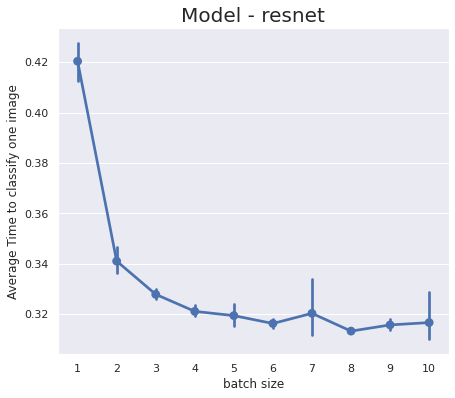

In [ ]:
# Model 2 - alexnet 
start = time.time()
print()
print("Model 2: alexnet")
model2 = torchvision.models.alexnet(pretrained = True, progress = True)
model_name = "alexnet"
help_df_model2, help_df_augmented_model2 = batch_vs_average_time(model=model2,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model2, y_axis = "average time to classify one image in the batch",  model_name = model_name, show_plot = True)


Model 2: alexnet

Time taken:  0.21 Min
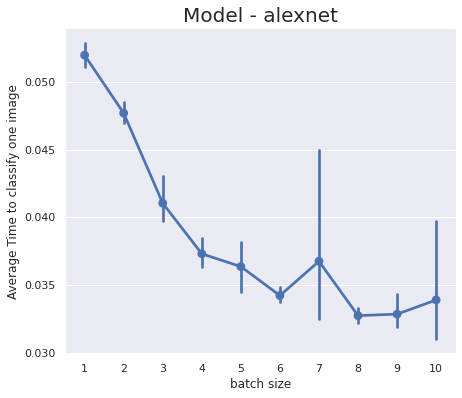

In [ ]:
# Model 3 - googlenet
start = time.time()
print()
print("Model 3: googlenet")
model3 = torchvision.models.googlenet(pretrained = True, progress = True)
model_name = "googlenet"
help_df_model3, help_df_augmented_model3 = batch_vs_average_time(model=model3,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model3, y_axis = "average time to classify one image in the batch",  model_name = model_name, show_plot = True)
print("---------------------------------------------------")


Model 3: googlenet

Time taken:  0.49 Min

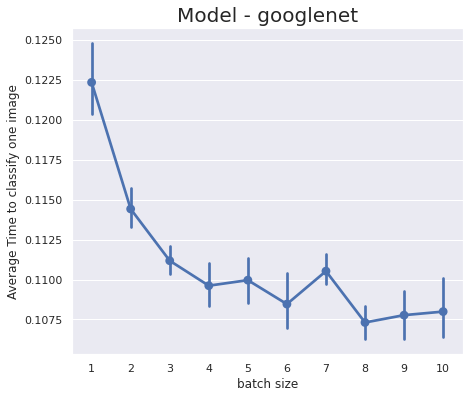

In [ ]:
# Model 4 - mobilenet_v2 
start = time.time()
print()
print("Model 4: mobilenet_v2")
model4 = torchvision.models.mobilenet_v2(pretrained = True, progress = True)
model_name = "mobilenet_v2"
help_df_model4, help_df_augmented_model4 = batch_vs_average_time(model=model4,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model4, y_axis = "average time to classify one image in the batch",   model_name = model_name, show_plot = True)


Model 4: mobilenet_v2

Time taken:  0.19 Min

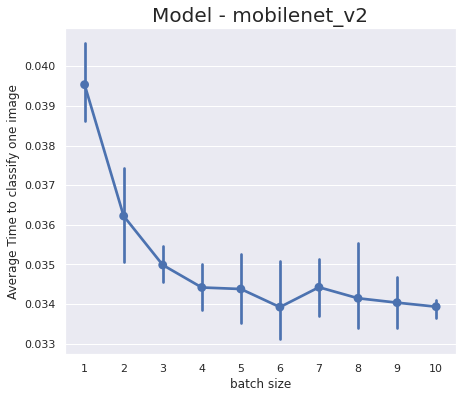

In [ ]:
# Model 5 - densenet161
start = time.time()
print()
print("Model 5: densenet161")
model5 = torchvision.models.densenet161(pretrained = True, progress = True)
model_name = "densenet161"
help_df_model5, help_df_augmented_model5 = batch_vs_average_time(model=model5,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")

if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model5, y_axis = "average time to classify one image in the batch",  model_name = model_name, show_plot = True)

Model 5: densenet161

Time taken:  1.56 Min

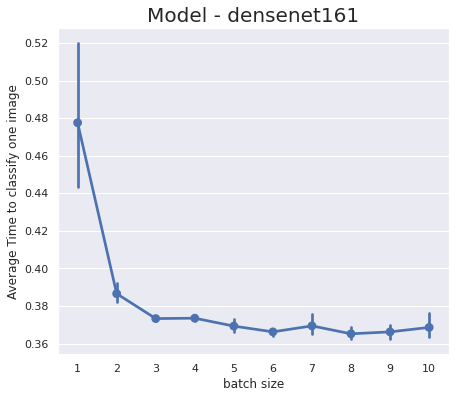

In [ ]:
help_df_model_join_cpu = help_df_model1.copy()
help_df_model_join_cpu.rename(columns = {"average_time_classify_one_image" : "Model 1 - resnet101"}, inplace = True)
help_df_model_join_cpu["Model 2 - alexnet"] = help_df_model2["average_time_classify_one_image"]
help_df_model_join_cpu["Model 3 - googlenet"] = help_df_model3["average_time_classify_one_image"]
help_df_model_join_cpu["Model 4 - mobilenet_v2"] = help_df_model4["average_time_classify_one_image"]
help_df_model_join_cpu["Model 5 - densenet161"] = help_df_model5["average_time_classify_one_image"]

plt.figure(figsize=(12,12))
plot = sns.pointplot(data = one_big_df_augmented,
                x = "batch size",
                y = "vals", hue = "cols", ci = 100)
plot.axes.set_title(title_grpah ,fontsize = 20)
plot.set_ylabel("Average Time to classify one image")

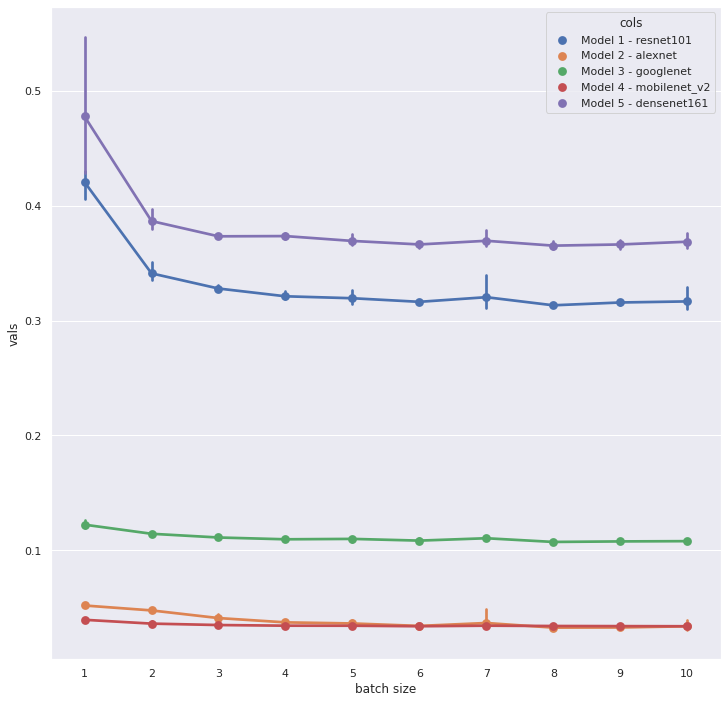

#### ii) Figure 2. Same graph as above, but for GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_file_name = "images_small" 
categories_file_name = "imagenet_classes.txt"
batch_jump = 1

In [ ]:
# Model 1 - resnet101 
start = time.time()
print()
print("Model 1: resnet101")
model1 = torchvision.models.resnet101(pretrained = True, progress = True)
model_name = "resnet"
help_df_model1, help_df_augmented_model1 = batch_vs_average_time(model=model1,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model1, y_axis ="average time to classify one image in the batch",  model_name = model_name, show_plot = True)


Model 1: resnet101

Time taken:  1.32 Min

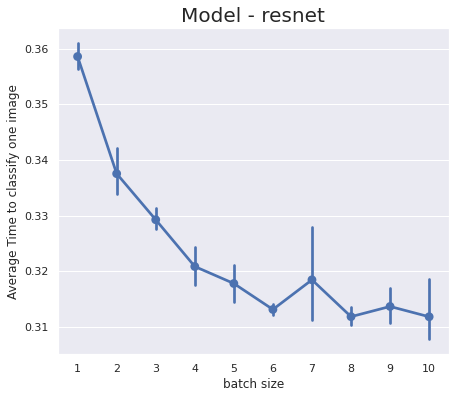

In [ ]:
#Model 2 - alexnet
start = time.time()
print()
print("Model 2: alexnet")
model2 = torchvision.models.alexnet(pretrained = True, progress = True)
model_name = "alexnet"
help_df_model2, help_df_augmented_model2 = batch_vs_average_time(model=model2,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model2, y_axis ="average time to classify one image in the batch",  model_name = model_name, show_plot = True)

Model 2: alexnet

Time taken:  0.22 Min

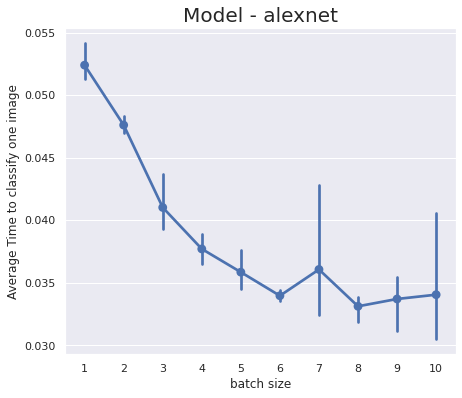

In [ ]:
# Model 3 - googlenet
start = time.time()
print()
print("Model 3: googlenet")
model3 = torchvision.models.googlenet(pretrained = True, progress = True)
model_name = "googlenet"
help_df_model3, help_df_augmented_model3 = batch_vs_average_time(model=model3,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model3, y_axis ="average time to classify one image in the batch",  model_name = model_name, show_plot = True)

Model 3: googlenet

Time taken:  0.49 Min

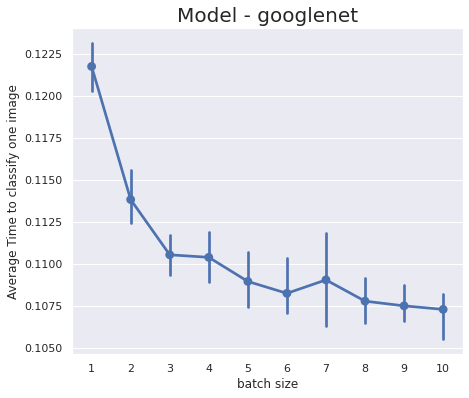

In [ ]:
# Model 4 - mobilenet_v2 
start = time.time()
print()
print("Model 4: mobilenet_v2")
model4 = torchvision.models.mobilenet_v2(pretrained = True, progress = True)
model_name = "mobilenet_v2"
help_df_model4, help_df_augmented_model4 = batch_vs_average_time(model=model4,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model4,  y_axis ="average time to classify one image in the batch", model_name = model_name, show_plot = True)


Model 4: mobilenet_v2

Time taken:  0.19 Min

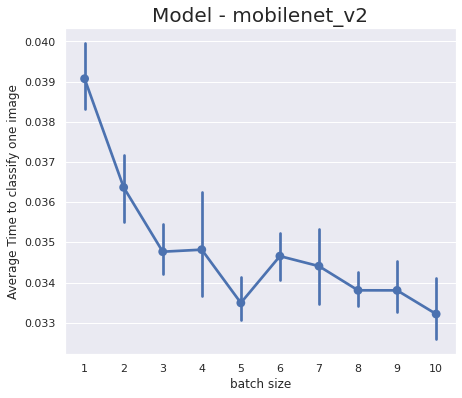

In [ ]:

# Model 5 - densenet161 
start = time.time()
print()
print("Model 5: densenet161")
model5 = torchvision.models.densenet161(pretrained = True, progress = True)
model_name = "densenet161"
help_df_model5, help_df_augmented_model5 = batch_vs_average_time(model=model5,
                                      image_file_name=image_file_name, device = device,
                                      batch_min_size = 1, batch_max_size = "half", batch_jump = batch_jump)
end = time.time()
print("Time taken: ", (end-start)/60, "Min")
print("---------------------------------------------------")
if plot_each_grah:
    plot_average_time_vs_batch_size(help_df_augmented_model5,  y_axis ="average time to classify one image in the batch", model_name = model_name, show_plot = True)

Model 5: densenet161

Time taken:  1.51 Min

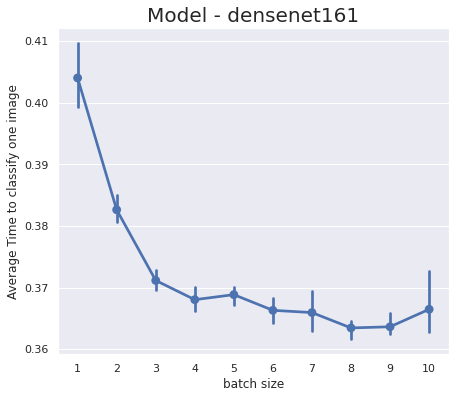

In [ ]:
#creating one big plot for figure 3
help_df_model_join_GPU_small = help_df_model1.copy()
help_df_model_join_GPU_small.rename(columns = {"average_time_classify_one_image" : "Model 1 -resnet101 GPU"}, inplace = True)
help_df_model_join_GPU_small["Model 2 - alexnet GPU"] = help_df_model2["average_time_classify_one_image"]
help_df_model_join_GPU_small["Model 3 - googlenet GPU"] = help_df_model3["average_time_classify_one_image"]
help_df_model_join_GPU_small["Model 4 - mobilenet_v2 GPU"] = help_df_model4["average_time_classify_one_image"]
help_df_model_join_GPU_small["Model 5 - densenet161 GPU"] = help_df_model5["average_time_classify_one_image"]
help_df_model_join_GPU_small

In [ ]:
plt.figure(figsize=(12,12))

plot = sns.pointplot(data = one_big_df_GPU,
                x = "batch size",
                y = "vals", hue = "cols", ci = 100)

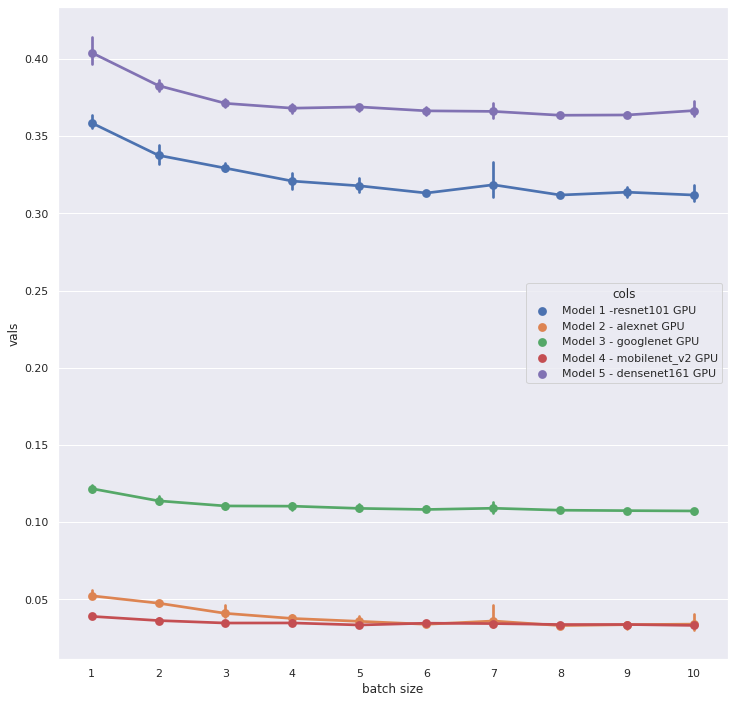

#### iii) Figure 3. The last figure should directly compare CPU and GPU performance. It should
plot the ratio between the time needed to classify image using GPU to CPU in the same
batch for variety of batch sizes.

In [ ]:
compare_cpu_gpu_table = pd.merge(help_df_model_join_cpu, help_df_model_join_GPU_small, on = "batch size")
compare_cpu_gpu_table["Model 1 - GPU/CPU"] = compare_cpu_gpu_table["Model 1 -resnet101 GPU"]/compare_cpu_gpu_table["Model 1 - resnet101"]
compare_cpu_gpu_table["Model 2 - GPU/CPU"] = compare_cpu_gpu_table["Model 2 - alexnet GPU"]/compare_cpu_gpu_table["Model 2 - alexnet"]
compare_cpu_gpu_table["Model 3 - GPU/CPU"] = compare_cpu_gpu_table["Model 3 - googlenet GPU"]/compare_cpu_gpu_table["Model 3 - googlenet"]
compare_cpu_gpu_table["Model 4 - GPU/CPU"] = compare_cpu_gpu_table["Model 4 - mobilenet_v2 GPU"]/compare_cpu_gpu_table["Model 4 - mobilenet_v2"]
compare_cpu_gpu_table["Model 5 - GPU/CPU"] = compare_cpu_gpu_table["Model 5 - densenet161 GPU"]/compare_cpu_gpu_table["Model 5 - densenet161"]

compare_cpu_gpu_table[["batch size","Model 1 - GPU/CPU","Model 2 - GPU/CPU","Model 3 - GPU/CPU", "Model 4 - GPU/CPU","Model 5 - GPU/CPU"]]

In [ ]:
one_big_compare_df = compare_cpu_gpu_table.copy()
one_big_compare_df = one_big_compare_df[["batch size","Model 1 - GPU/CPU","Model 2 - GPU/CPU","Model 3 - GPU/CPU", "Model 4 - GPU/CPU","Model 5 - GPU/CPU"]]
one_big_compare_df = one_big_compare_df.melt('batch size', var_name='cols',  value_name='vals')
one_big_compare_df.head()

In [ ]:
plt.figure(figsize=(12,12))

plot = sns.pointplot(data = one_big_compare_df,
                x = "batch size",
                y = "vals", hue = "cols", ci = 5)

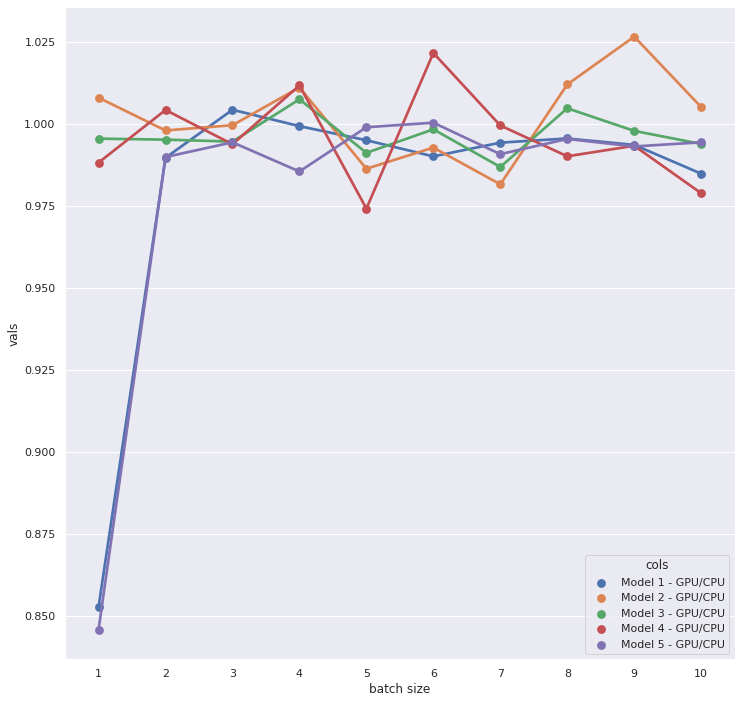

# Question 2

### Description: 
1. Use torch.hub to load and run a pretrained model of your choice. For this assignment, you
should search github.com for a model that is compatible with pytorch hub. 
2. Load the model into Jupyter notebook and demonstrate its use.
3. Explain briefly what this model is designed to do. 

In [90]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)




Using cache found in C:\Users\wings/.cache\torch\hub\pytorch_vision_v0.6.0


In [109]:

# Open the file in read mode
with open('imagenet_classes.txt', 'r') as file:
  # Read the contents of the file into a list and save it to a variable
  lines = file.readlines()

# Save the contents of the file to a variable
data_labels_list = lines

In [112]:
import torchvision

# Load the model
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

# Preprocess the input image
image = PIL.Image.open('cat.jpeg')
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

# Run the model and get the prediction
output = model(input_tensor)
_, prediction = output.max(1)

# Convert the prediction to a class label using the ImageNet class labels
ImageNet = torchvision.datasets.ImageNet
prediction_label = data_labels_list[prediction]
print(f'Predicted class: {prediction_label}')


Using cache found in C:\Users\wings/.cache\torch\hub\pytorch_vision_v0.6.0


Predicted class: bucket, pail



 #### What does this model is desgined to do?

#### Answer:
The ResNet-50 model is a convolutional neural network (CNN) trained on the ImageNet dataset for image classification. It is designed to recognize and classify objects in images into one of 1000 predefined classes.

Once the model is loaded, you can use it to make predictions on your own images by preprocessing the input images and passing them through the model.


The code above will resize and crop the input image to the required dimensions, convert it to a tensor, and normalize it using the mean and standard deviation values provided. It will then pass the tensor through the model (ResNet-50) and get the prediction. Finally, it will convert the predicted class index to a label using the ImageNet.idx_to_class dictionary provided by the PyTorch vision library.

# Question 3

### Description: 
Practice exporting traditional machine learning models into ONNX.

For this assignment you will have to install skl2onnx and onnxruntime (onnxruntime-gpu if you have access to GPU) libraries.

Train traditional ML model. We recommend using one of the assignments you’ve
performed last year. This could be a linear or logistic regression, decision tree classifier or
regressor, random forest or a clustering algorithm of your choice. |


a) Train the algorithm and demonstrate its prediction for few cases.

b) Save the algorithm into ONNX file.

c) Load ONNX file using onnx runtime.

d) Demonstrate that onnx runtime can perform predictions identical to that of scikit learn. 

In [14]:
#pip install skl2onnx
#pip install onnxruntime
#pip install onnxruntime-gpu

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, mean_squared_error
import skl2onnx
import onnxruntime

## a) 

In [36]:
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



"""
This code will load the data into a Pandas data frame,
split the data into training and test sets, and then train a linear regression model using the training data.
It will then make predictions on the test set using the trained model.

"""
# Load the data into a Pandas data frame
df = pd.read_csv('Real estate.csv')

# Split the data into training and test sets
X = df.drop(labels=["Y house price of unit area"], axis = 1)
y = df["Y house price of unit area"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = regression_model.predict(x_test)



In [43]:
preidction_scikit = y_pred

## b) 

In [38]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

onnx_file_name ="Real estate.onnx"

initial_type = [('X', FloatTensorType([None, x_train.shape[1]]))] #FloatTensorType
onx = convert_sklearn(regression_model, initial_types=initial_type)
with open(onnx_file_name, "wb") as f:
    f.write(onx.SerializeToString())

## c) 

In [41]:
import onnxruntime

x_test_array = x_test.values
x_test_array = x_test_array.astype(np.float32)


# Load the ONNX file
onnx_path = onnx_file_name


session = onnxruntime.InferenceSession(onnx_path)

# Get the input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Run the model and get the prediction
input_data = x_test_array # this should be a NumPy array with the same shape as the model's input
prediction = session.run([output_name], {input_name: input_data})[0]


In [44]:
prediction_ONNX = prediction

In [79]:
for i in range(prediction_ONNX.shape[0]):
    pred_ONNX = round(prediction_ONNX[i][0],1)
    pred_sckit = round(preidction_scikit[i],1)
    if pred_ONNX == pred_sckit:
        print("the predictions are the same! ")

the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the predictions are the same! 
the pred

#### We can obiuosly see that the prediction are the same! :)